
### Introduction

Generating synthetic data is a crucial task in machine learning and data science to overcome the limitations of real-world datasets. One such limitation is the availability of sufficient, diverse, and balanced data for training models. In this scenario, we are working with the Pakistani Diabetes Dataset, which has 486 records for diabetic patients and 426 records for non-diabetic patients. The dataset contains 18 predictor attributes and one target attribute named 'Outcome', where 0 represents diabetes-negative cases and 1 represents diabetes-positive cases.

However, due to privacy concerns or limited access to the original data, using only this real-world dataset may not be feasible for everyone. Therefore, generating synthetic data that mimics the statistical properties of the original dataset can help researchers and practitioners develop and test machine learning models without directly accessing sensitive information.

In this notebook, we will use ctGAN (Conditional Generative Adversarial Network) to generate synthetic data based on the Pakistani Diabetes Dataset.

### About Dataset

Pakistani Diabetes Dataset was created by Dr Muhammad Shoaib and one of his research students, Aysha Qamar. The diabetic patients dataset (486 records) was collected from District Headquarter Teaching Hospital (DHQTH), Sahiwal, Pakistan under the supervision of Dr. Sarfaraz Ahmad Khan, senior registrar and diabetes mellitus specialist, DHQTH, Sahiwal. The non-diabetic patients dataset (426 records) was collected by hosting a medical camp at COMMSATS University Islamabad, Sahiwal Campus, Sahiwal, Pakistan under the supervision of Dr Sarfaraz Ahmad Khan and his team from DHQTH, Sahiwal.

This dataset contains 18 predictor attributes and one target attribute named 'Outcome' having 0 and 1 as diabetes-ve and diabetes+ve respectively.

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optimy
import numpy as np
from ctgan import CTGAN
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
df = pd.read_csv("/kaggle/input/pakistani-diabetes-dataset/Pakistani_Diabetes_Dataset.csv")
df

,Age,Gender,Rgn,wt,BMI,wst,sys,dia,his,A1c,B.S.R,vision,Exr,dipsia,uria,Dur,neph,HDL,Outcome
0,60.0,1,0,76.0,29.90,41.0,130,90,0,8.90,278,0,30,1,0,5.0,0,60,1
1,57.0,1,1,64.0,24.30,39.0,120,80,1,8.50,165,0,20,1,1,20.0,0,42,1
2,58.0,0,0,73.0,25.20,34.0,140,90,0,5.65,130,1,20,0,0,0.0,0,54,0
3,27.0,0,1,60.0,22.01,30.0,110,70,0,5.00,95,0,15,0,0,0.0,0,57,0
4,56.0,1,0,70.0,25.80,43.0,125,90,0,8.30,139,1,40,1,0,5.0,1,53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,22.0,0,0,54.0,17.08,40.0,143,85,1,5.00,165,0,15,0,0,0.0,0,54,0
908,32.0,0,1,52.0,18.50,28.0,138,95,1,4.70,87,0,0,0,0,0.0,0,54,0
909,22.0,0,0,78.0,26.14,32.0,183,88,1,4.50,100,0,0,1,0,0.0,0,40,1
910,18.0,1,1,53.0,20.05,33.0,195,93,1,4.70,74,1,15,0,0,0.0,0,46,0



## Renaming Features for Better Readability


Previously, the feature names in our dataset were not very descriptive and made little sense. Based on best knowledge and common understanding of medical terms, we have renamed these features to make them more readable. Here are the new names along with a brief explanation:

- **weight_kg**: Weight of the individual measured in kilograms.
- **body_mass_index**: Body Mass Index (BMI) calculated from weight and height.
- **waist_inches**: Waist circumference measured in inches.
- **systolic_bp**: Systolic blood pressure, the upper number in a blood pressure reading.
- **diastolic_bp**: Diastolic blood pressure, the lower number in a blood pressure reading.
- **familyhist_diabetes**: Family history of diabetes (yes/no).
- **hemoglobina1c**: Hemoglobin A1C level, an indicator of blood sugar control over time.
- **blood_sugar_random**: Random blood glucose level measured without fasting.
- **vision_impair**: Vision impairment or loss (yes/no).
- **exercise_minutes**: Number of minutes spent exercising per week.
- **polydipsia**: Excessive thirst experienced by the individual.
- **polyuria**: Frequent urination experienced by the individual.
- **diabetes_duration**: Duration of diabetes diagnosis in years.
- **nephropathy**: Kidney disease related to diabetes.
- **hdl_cholesterol**: HDL (High-Density Lipoprotein) cholesterol level, often called "good" cholesterol.
- **diabetes_outcome**: Outcome or classification related to diabetes.

These new names should provide a clearer understanding of the data's context and help in better analysis.

In [5]:
df.rename(columns={
    "wt": "weight_kg",
    "BMI": "body_mass_index",
    "wst": "waist_inches",
    "sys": "systolic_bp",
    "dia": "diastolic_bp",
    "his": "familyhist_diabetes",
    "A1c": "hemoglobina1c",
    "B.S.R": "blood_sugar_random",
    "vision": "vision_impair",
    "Exr": "exercise_minutes",
    "dipsia": "polydipsia",
    "uria": "polyuria",
    "Dur": "diabetes_duration",
    "neph": "nephropathy",
    "HDL": "hdl_cholesterol",
    "Outcome": "diabetes_outcome",
},
inplace=True)

## Data Cleaning

In [6]:
print("Number of dublicates:", df.duplicated().sum())
print(df.isnull().sum())

Number of dublicates: 2
Age                    0
Gender                 0
Rgn                    0
weight_kg              0
body_mass_index        0
waist_inches           0
systolic_bp            0
diastolic_bp           0
familyhist_diabetes    0
hemoglobina1c          0
blood_sugar_random     0
vision_impair          0
exercise_minutes       0
polydipsia             0
polyuria               0
diabetes_duration      0
nephropathy            0
hdl_cholesterol        0
diabetes_outcome       0
dtype: int64


In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 0 to 911
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  910 non-null    float64
 1   Gender               910 non-null    int64  
 2   Rgn                  910 non-null    int64  
 3   weight_kg            910 non-null    float64
 4   body_mass_index      910 non-null    float64
 5   waist_inches         910 non-null    float64
 6   systolic_bp          910 non-null    int64  
 7   diastolic_bp         910 non-null    int64  
 8   familyhist_diabetes  910 non-null    int64  
 9   hemoglobina1c        910 non-null    float64
 10  blood_sugar_random   910 non-null    int64  
 11  vision_impair        910 non-null    int64  
 12  exercise_minutes     910 non-null    int64  
 13  polydipsia           910 non-null    int64  
 14  polyuria             910 non-null    int64  
 15  diabetes_duration    910 non-null    float64


## Basic Preprocessing & EDA

In [9]:
#Code to change the datatype of categorical variables to uint8
df["familyhist_diabetes"] = df["familyhist_diabetes"].astype("uint8")
df["vision_impair"] = df["vision_impair"].astype("uint8")
df["polydipsia"] = df["polydipsia"].astype("uint8")
df["polyuria"] = df["polyuria"].astype("uint8")
df["nephropathy"] = df["nephropathy"].astype("uint8")
df["diabetes_outcome"] = df["diabetes_outcome"].astype("uint8")
df["Gender"] = df["Gender"].astype("uint8")


In [10]:
#Clipping the values that exceed the actual possible health measurements
df['body_mass_index'] = df['body_mass_index'].clip(upper=60)
df['waist_inches'] = df['waist_inches'].clip(upper=50)
df['systolic_bp'] = df['systolic_bp'].clip(upper=210  )

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Rgn '}>,
        <Axes: title={'center': 'weight_kg'}>],
       [<Axes: title={'center': 'body_mass_index'}>,
        <Axes: title={'center': 'waist_inches'}>,
        <Axes: title={'center': 'systolic_bp'}>,
        <Axes: title={'center': 'diastolic_bp'}>],
       [<Axes: title={'center': 'familyhist_diabetes'}>,
        <Axes: title={'center': 'hemoglobina1c'}>,
        <Axes: title={'center': 'blood_sugar_random'}>,
        <Axes: title={'center': 'vision_impair'}>],
       [<Axes: title={'center': 'exercise_minutes'}>,
        <Axes: title={'center': 'polydipsia'}>,
        <Axes: title={'center': 'polyuria'}>,
        <Axes: title={'center': 'diabetes_duration'}>],
       [<Axes: title={'center': 'nephropathy'}>,
        <Axes: title={'center': 'hdl_cholesterol'}>,
        <Axes: title={'center': 'diabetes_outcome'}>, <Axes: >]],
      dtype=object)

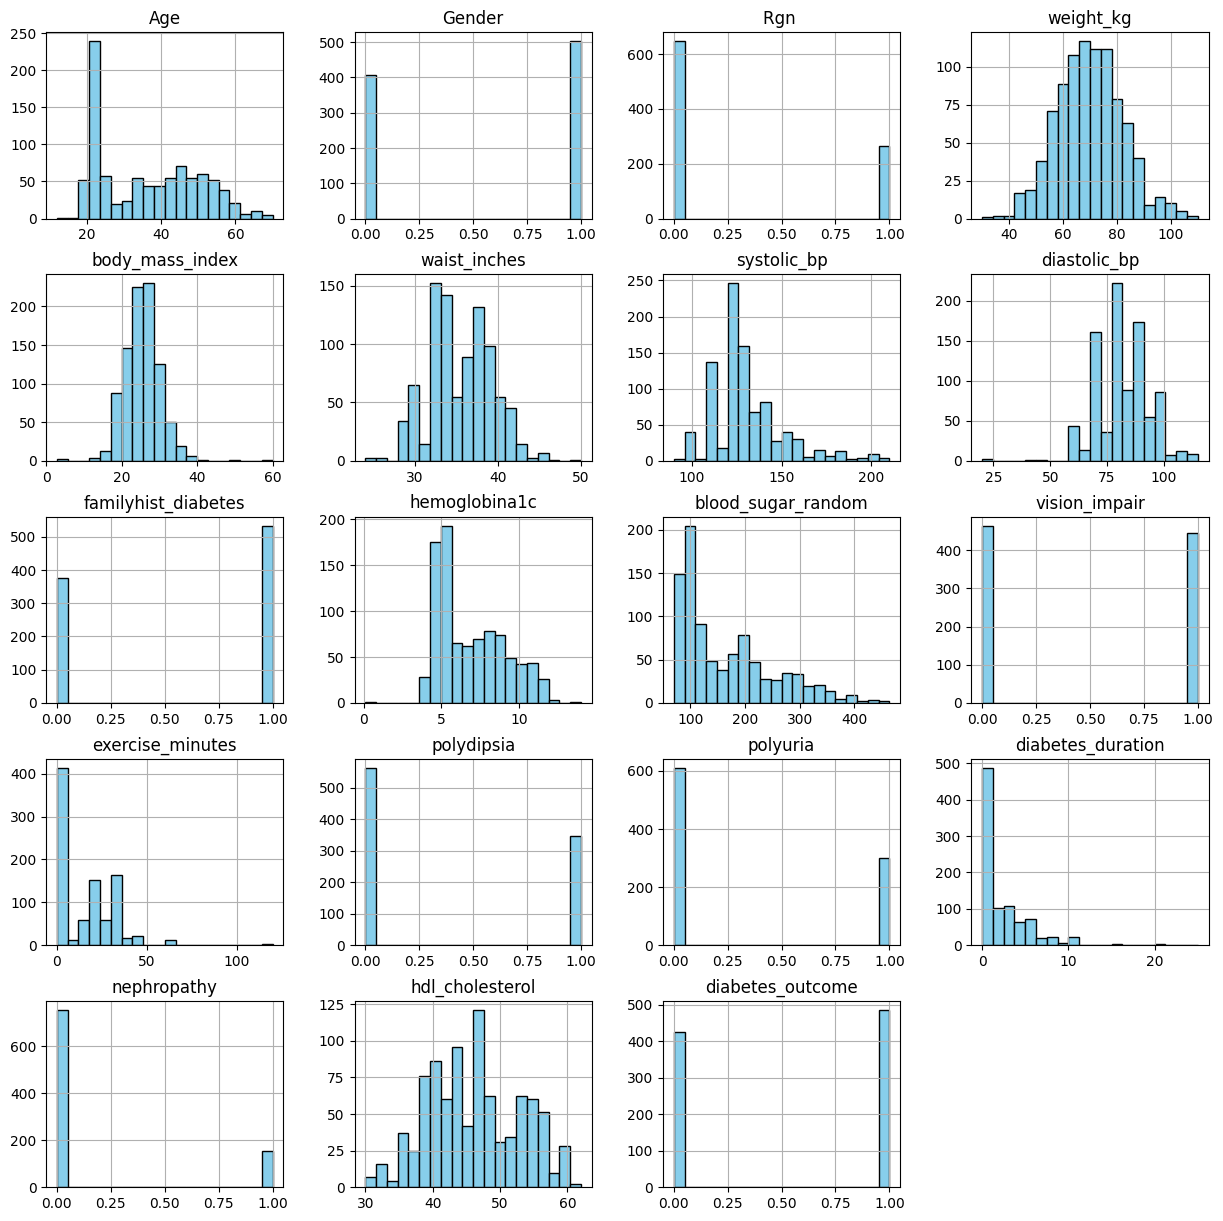

In [11]:
#Histogram for distribution of data
df.hist(figsize=(15,15), bins=20, color='skyblue', edgecolor='black')

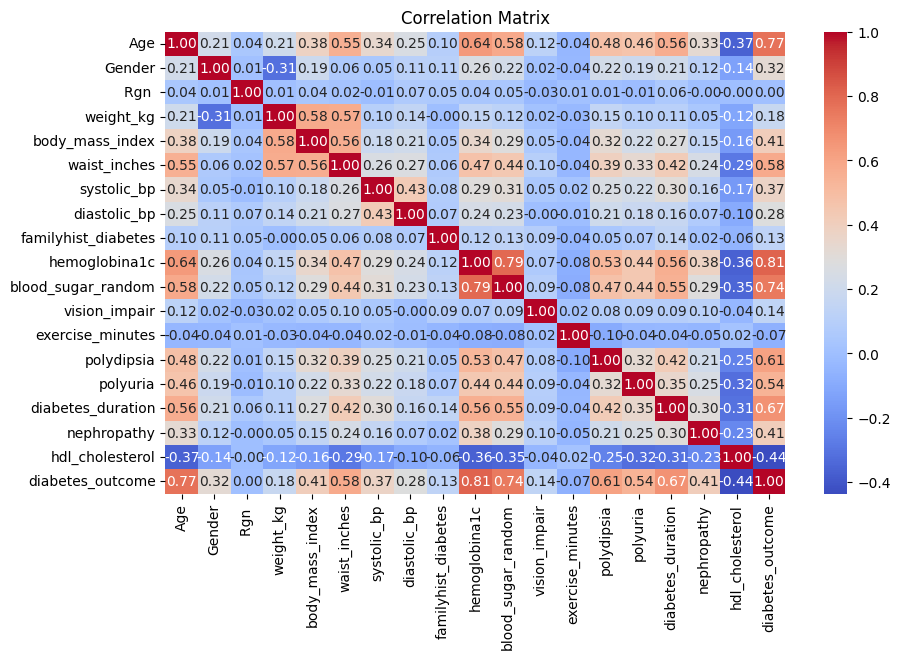

In [12]:
# 2. Plot the correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

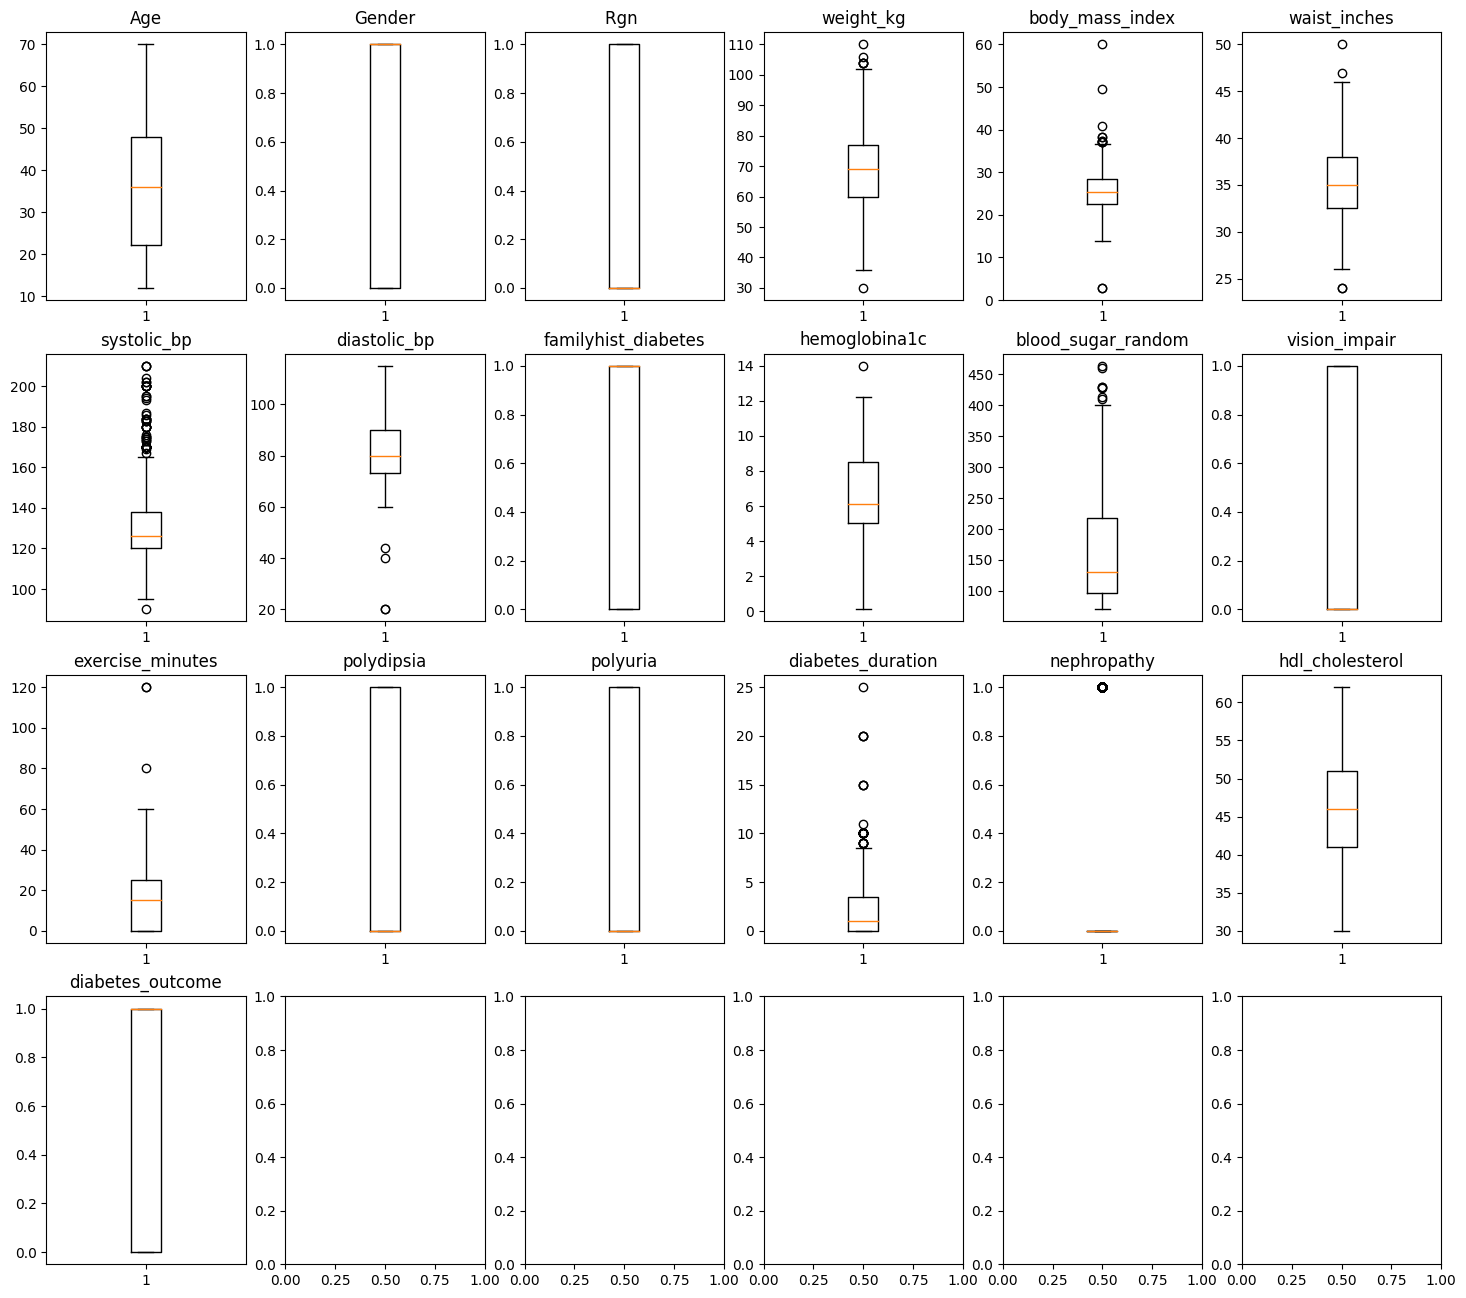

In [13]:
n_cols = 6
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))  # Create grid

axes = axes.flatten()  # Flatten the 2D array into 1D
for i, column in enumerate(df.columns):  # Loop through all 18 columns
        axes[i].boxplot(df[column])  # Plot the boxplot on the ith subplot
        axes[i].set_title(f"{column}")
plt.show()

**Observations:**

In medical data, outliers are often considered rare and significant events. These outliers can be due to various reasons such as measurement errors, equipment malfunctions, or patient-specific factors. In the context of CTGAN (Conditional Generative Adversarial Network), we will not be performing any outlier cleaning during data generation. This decision is made to ensure that all potentially valuable and meaningful data points are retained for analysis.




## Prepare For Generative Training

In [14]:
print(torch.cuda.is_available())  # Should return True

True


In [15]:
print(torch.version.cuda)  # PyTorch's CUDA version
print(torch.cuda.is_available())  # Check if CUDA is available


12.1
True


In [16]:
ctgan = CTGAN(
    epochs=1000,  # Increase epochs
    batch_size=80,  # Experiment with batch size
    generator_dim=(256, 256, 256),  # Adjust generator architecture
    discriminator_dim=(512, 512, 512),  # Adjust discriminator architecture
    pac=1,  # Number of samples to group together when applying the discriminator
    verbose=True,
    cuda=True,
)

# Step 2: Train CTGAN on your dataset
ctgan.fit(df)

Gen. (0.00) | Discrim. (0.00):   0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Gen. (-0.41) | Discrim. (-0.23): 100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


- `epochs=1000`: This parameter sets the number of times the entire dataset will be passed through the model during training. Increasing this value can help improve the model's performance, but it also increases computational time.
- `batch_size=80`: The batch size determines how many samples are processed before the model’s internal parameters are updated. A higher batch size can lead to more stable gradient estimates and potentially faster convergence, but it requires more memory.
- `generator_dim=(256, 256, 256)`: This parameter defines the dimensions of the generator network's architecture in a three-dimensional setting (e.g., for volumetric data). Adjusting these values can impact the complexity and capacity of the generator model.
- `discriminator_dim=(512, 512, 512)`: Similarly, this parameter sets the discriminator network’s architecture dimensions. Higher values can allow the discriminator to capture more complex patterns but also increase computational demands.
- `pac=1`: This means that each sample is evaluated individually by the discriminator, which can sometimes lead to less effective training as it doesn't account for the global structure of the data.
- `verbose=True`: This flag enables detailed output during the training process, which can be useful for monitoring progress and debugging.
- `cuda=True`: This parameter specifies that the model should run on a CUDA-enabled GPU if available, accelerating the training process significantly.

These parameters can be adjusted based on specific requirements, computational resources, and the complexity of the task.

In [17]:
samples = ctgan.sample(910)
df_gnt = pd.DataFrame(samples,columns=df.columns)

In [18]:
df_gnt.head(5)

,Age,Gender,Rgn,weight_kg,body_mass_index,waist_inches,systolic_bp,diastolic_bp,familyhist_diabetes,hemoglobina1c,blood_sugar_random,vision_impair,exercise_minutes,polydipsia,polyuria,diabetes_duration,nephropathy,hdl_cholesterol,diabetes_outcome
0,35.054374,0,0,75.591059,23.793012,34.742227,113,69,0,4.708025,82,0,26,0,0,-0.095595,0,56,0
1,19.777834,1,1,65.429881,25.302871,37.801424,111,68,1,5.291701,71,1,14,0,0,-0.135717,1,48,0
2,52.554833,1,1,76.497776,28.376592,43.160498,132,80,0,7.799694,158,0,-1,1,1,5.497252,0,36,1
3,21.558347,1,1,56.534484,22.109737,31.162303,116,66,0,5.157341,82,0,14,0,0,-0.102756,0,52,0
4,20.428646,0,1,62.010830,22.266503,34.170188,134,78,1,4.568509,64,1,14,0,0,-0.075769,0,56,0


In [19]:
df_gnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  910 non-null    float64
 1   Gender               910 non-null    uint8  
 2   Rgn                  910 non-null    int64  
 3   weight_kg            910 non-null    float64
 4   body_mass_index      910 non-null    float64
 5   waist_inches         910 non-null    float64
 6   systolic_bp          910 non-null    int64  
 7   diastolic_bp         910 non-null    int64  
 8   familyhist_diabetes  910 non-null    uint8  
 9   hemoglobina1c        910 non-null    float64
 10  blood_sugar_random   910 non-null    int64  
 11  vision_impair        910 non-null    uint8  
 12  exercise_minutes     910 non-null    int64  
 13  polydipsia           910 non-null    uint8  
 14  polyuria             910 non-null    uint8  
 15  diabetes_duration    910 non-null    flo

## General Evaluation 

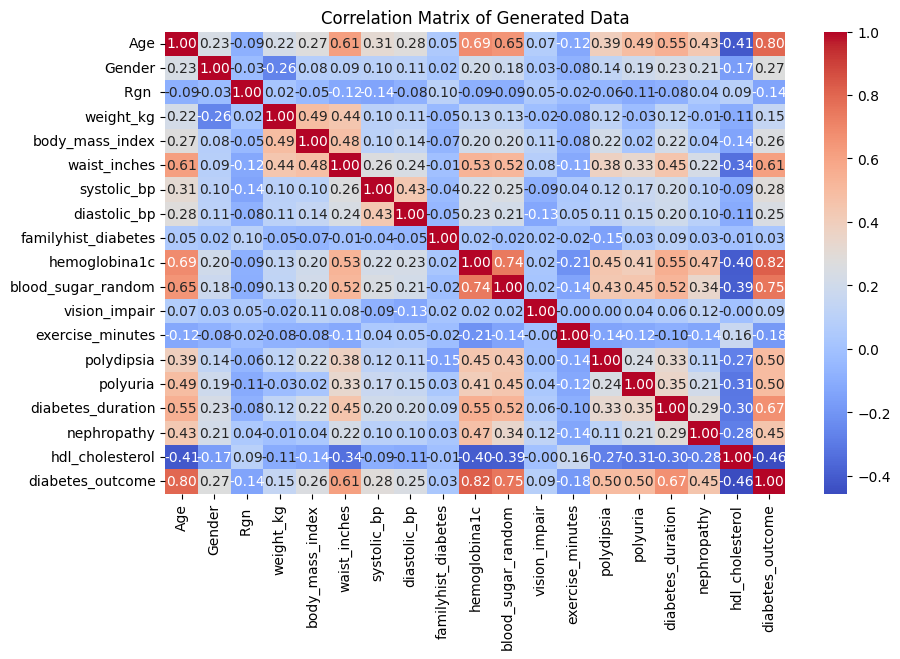

In [20]:
plt.figure(figsize=(10,6))
correlation_matrix = df_gnt.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Generated Data")
plt.show()

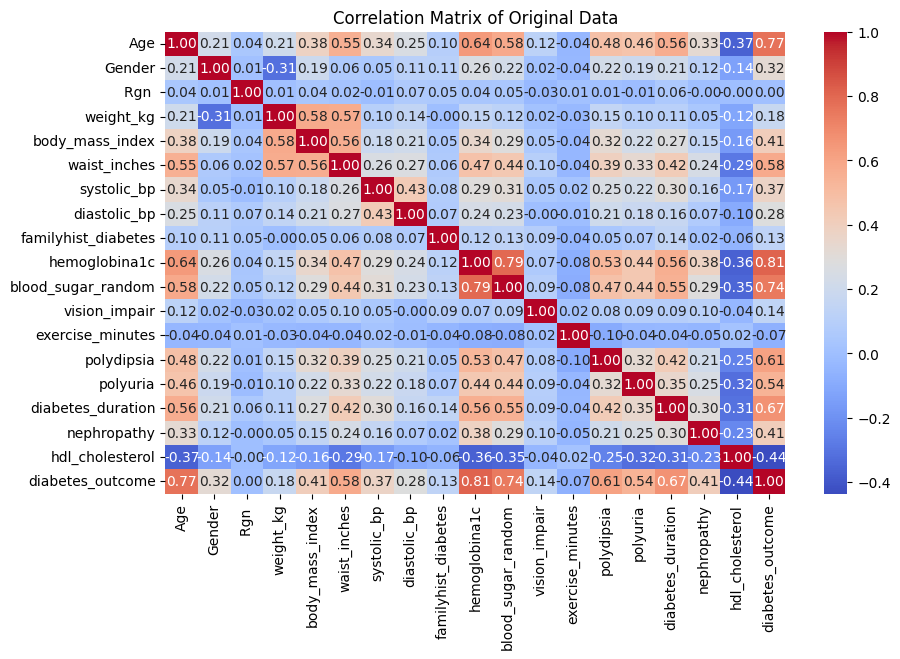

In [21]:
plt.figure(figsize=(10,6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Original Data")
plt.show()

In [23]:
# Compare summary statistics
summary_stats_original = df.describe()
summary_stats_synthetic = df_gnt.describe()

print("\nSummary Statistics - Original Data:")
print(summary_stats_original)

print("\nSummary Statistics - Generated Data:")
print(summary_stats_synthetic)


Summary Statistics - Original Data:
              Age      Gender        Rgn    weight_kg  body_mass_index  \
count  910.000000  910.000000  910.000000  910.000000       910.000000   
mean    36.304945    0.552747    0.289011   69.369451        25.441633   
std     13.513210    0.497483    0.453552   12.179145         4.664164   
min     12.000000    0.000000    0.000000   30.000000         2.840000   
25%     22.250000    0.000000    0.000000   60.000000        22.512500   
50%     36.000000    1.000000    0.000000   69.000000        25.260000   
75%     48.000000    1.000000    1.000000   77.000000        28.300000   
max     70.000000    1.000000    1.000000  110.000000        60.000000   

       waist_inches  systolic_bp  diastolic_bp  familyhist_diabetes  \
count    910.000000   910.000000    910.000000           910.000000   
mean      35.452198   129.603297     82.352747             0.586813   
std        3.781718    19.529217     11.834380             0.492677   
min       24

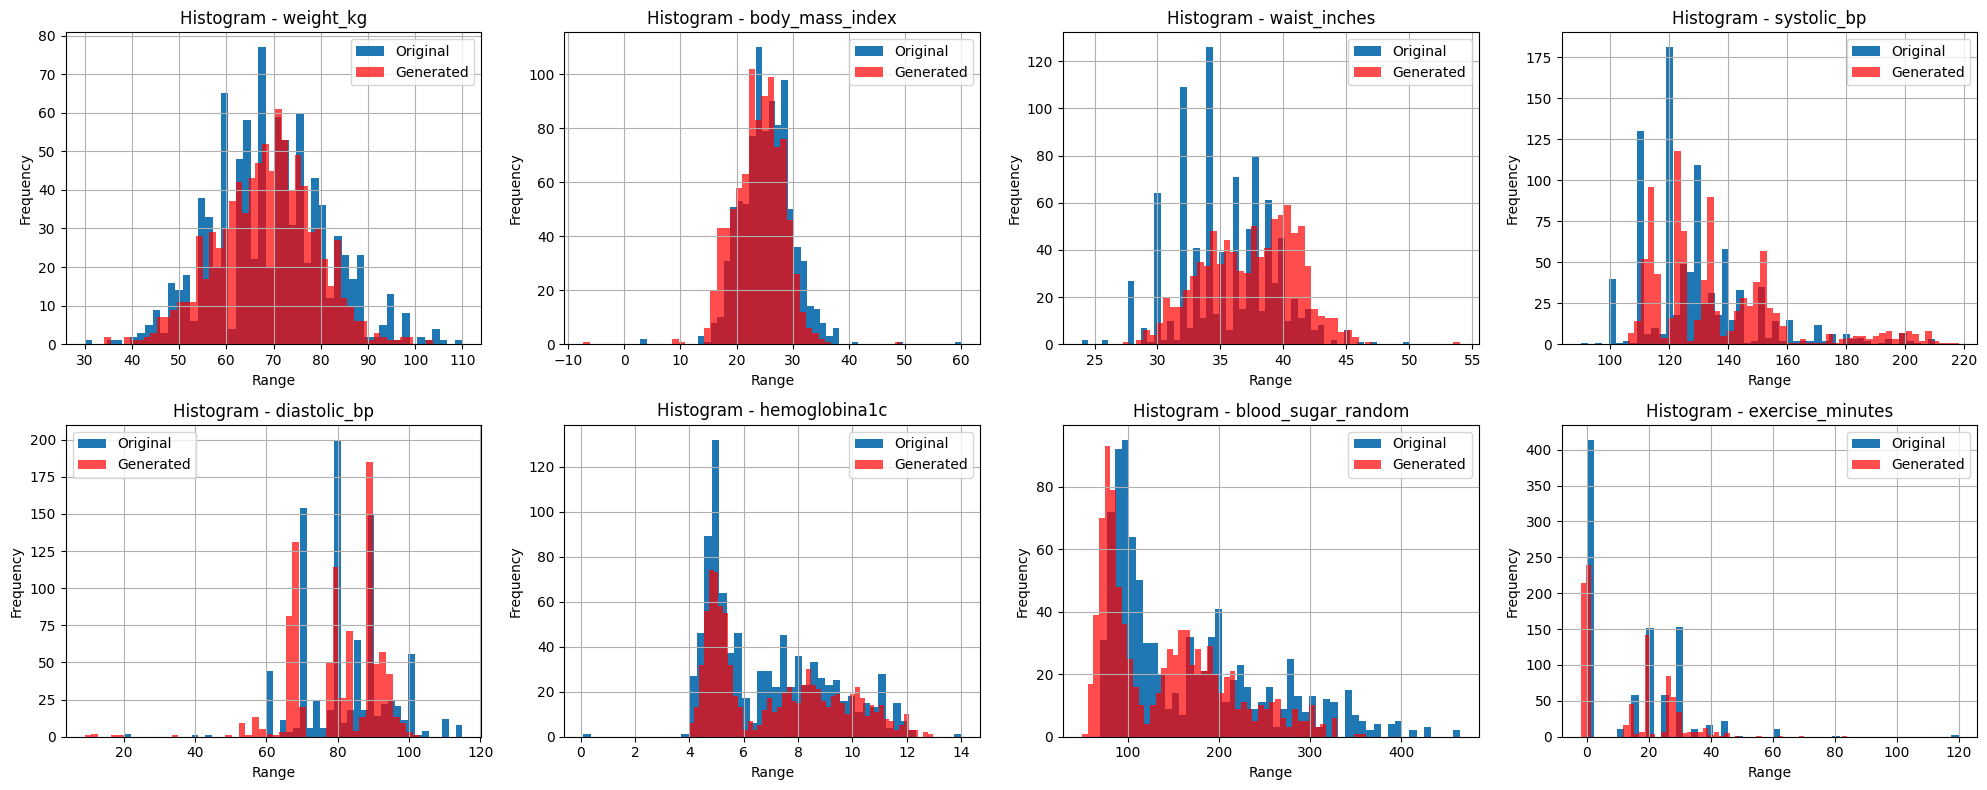

In [24]:
# Plot histograms for continuous variables
continuous_vars = ["weight_kg", "body_mass_index", "waist_inches", 
                   "systolic_bp", "diastolic_bp", "hemoglobina1c",
                   "blood_sugar_random", "exercise_minutes"]

plt.figure(figsize=(20, 8))
for i, var in enumerate(continuous_vars):
    plt.subplot(2, 4, i+1)
    df[var].hist(bins=50, label="Original")
    df_gnt[var].hist(bins=50, alpha=0.7, color='red', label="Generated")
    plt.title(f"Histogram - {var}")
    plt.xlabel("Range")  # X-axis label
    plt.ylabel("Frequency")       # Y-axis label
    plt.legend()
plt.tight_layout()
plt.show()

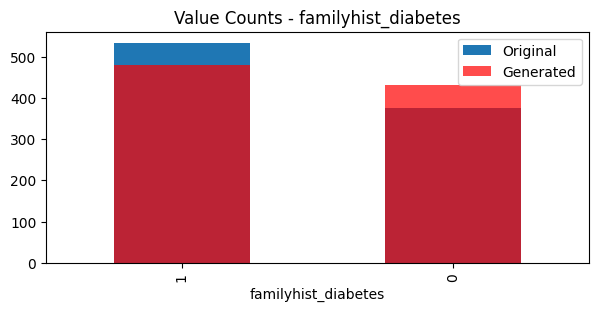

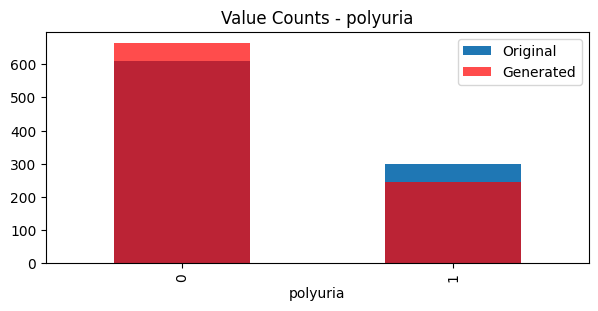

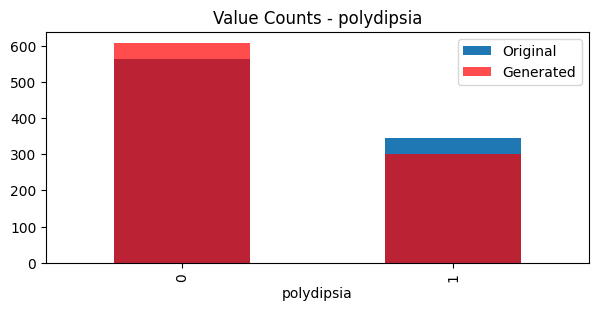

In [25]:
# Plot density plots for categorical variables
categorical_vars = ["familyhist_diabetes", "polyuria", "polydipsia"]

for var in categorical_vars:
    plt.figure(figsize=(7, 3))
    df[var].value_counts().plot(kind='bar', label="Original")
    df_gnt[var].value_counts().plot(kind='bar', alpha=0.7, color='red', label="Generated")
    plt.title(f"Value Counts - {var}")
    plt.legend()
    plt.show()

### Summary Statistics Comparison

#### Similarities:
- Both datasets have a count of 912 for each column.
- The number of unique values in the gender column is approximately the same (0.55 for males, 0.45 for females).
- The minimum, maximum, and some percentiles (e.g., 75th percentile) are similar.

#### Differences:

##### Demographics & Health Parameters
1. **Age:**
   - **Original:** Mean = 36.32, Standard Deviation = 13.52.
   - **Generated:** Mean = 35.97, Standard Deviation = 12.25.

2. **Body Mass Index (BMI):**
   - **Original:** Mean = 25.44, Standard Deviation = 4.66.
   - **Generated:** Mean = 28.90, Standard Deviation = 4.55.

3. **Waist Inches:**
   - **Original:** Mean = 35.44, Standard Deviation = 3.78.
   - **Generated:** Mean = 37.29, Standard Deviation = 3.70.

4. **Blood Pressure:**
   - Both systolic and diastolic blood pressures show similar distributions in both datasets.

5. **Hemoglobin A1c (HbA1c):**
   - **Original:** Mean = 6.86, Standard Deviation = 2.19.
   - **Generated:** Mean = 6.89, Standard Deviation = 2.12.

##### Disease Indicators
- **Family History of Diabetes:**
  - **Original:** Around 0.29 (32.7%) with diabetes in family history.
  - **Generated:** Around 0.56, indicating a higher proportion with a family history of diabetes.

- **Exercise Minutes:**
  - **Original:** Mean = 14.43 minutes, Standard Deviation = 15.60.
  - **Generated:** Mean = 12.67 minutes, Standard Deviation = 13.37.

- **Polydipsia and Polyuria:**
   - **Original:** About 0.38% with polydipsia and 0.42% with polyuria.
   - **Generated:** Around 0.39% for both, showing a similar distribution in these indicators.

- **Diabetes Outcome:**
  - **Original:** Mean = 0.53, indicating approximately 53% had a positive diabetes outcome.
  - **Generated:** Mean = 0.54, which is very close to the original.

#### Observations
1. The **age distribution** in the generated data is younger compared to the original dataset, with a higher mean and lower standard deviation.
2. The **BMI** and **waist circumference** are significantly higher in the generated data.
3. There's a noticeable increase in indicators related to diabetes, such as HbA1c levels and family history of diabetes.
4. There seems to be class imbalance among the categorical values of both the generated and original data indicating that the model has traced the underlying imbalances effectively.
5. Overall, the histograms for continous variables seems to look identical for generated and original data.

## Predictive Model Training

**Step1: Prepare the Datasets and Train/Test Splits**

In [28]:
# Load datasets
original_df = df
synthetic_df = df_gnt

In [29]:
# Split into features (X) and target variable (y)

#Original Data
X_original = original_df.drop("diabetes_outcome", axis=1).astype(float)
y_original = original_df["diabetes_outcome"]


#Synthetic Data
X_synthetic = synthetic_df.drop("diabetes_outcome", axis=1).astype(float)
y_synthetic = synthetic_df["diabetes_outcome"]


In [30]:
# Split data into training and test sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)

**Step 2: Train a Model on Original Data**

In [32]:
# Train model on original data
model = RandomForestClassifier(random_state=42)
model.fit(X_train_orig, y_train_orig)

# Make predictions
y_pred_orig = model.predict(X_test_orig)
y_prob_orig = model.predict_proba(X_test_orig)[:, 1]

**Step 3: Evaluate the Model on Original Data**

In [33]:
# Calculate evaluation metrics for original data
acc_orig = accuracy_score(y_test_orig, y_pred_orig)
precision_orig = precision_score(y_test_orig, y_pred_orig)
recall_orig = recall_score(y_test_orig, y_pred_orig)
f1_orig = f1_score(y_test_orig, y_pred_orig)
roc_auc_orig = roc_auc_score(y_test_orig, y_prob_orig)

print(f"Original Data - Accuracy: {acc_orig:.4f}, Precision: {precision_orig:.4f}, Recall: {recall_orig:.4f}, F1-Score: {f1_orig:.4f}, ROC AUC: {roc_auc_orig:.4f}")

Original Data - Accuracy: 0.9890, Precision: 1.0000, Recall: 0.9802, F1-Score: 0.9900, ROC AUC: 0.9988


**Step 4: Train a Model on Synthetic Data**

In [34]:
# Train model on synthetic data
model.fit(X_train_syn, y_train_syn)

# Make predictions
y_pred_syn = model.predict(X_test_syn)
y_prob_syn = model.predict_proba(X_test_syn)[:, 1]

**Step 5: Evaluate the Model on Synthetic Data**

In [36]:
# Calculate evaluation metrics for synthetic data
acc_syn = accuracy_score(y_test_syn, y_pred_syn)
precision_syn = precision_score(y_test_syn, y_pred_syn)
recall_syn = recall_score(y_test_syn, y_pred_syn)
f1_syn = f1_score(y_test_syn, y_pred_syn)
roc_auc_syn = roc_auc_score(y_test_syn, y_prob_syn)

print(f"Synthetic Data - Accuracy: {acc_syn:.4f}, Precision: {precision_syn:.4f}, Recall: {recall_syn:.4f}, F1-Score: {f1_syn:.4f}, ROC AUC: {roc_auc_syn:.4f}")

Synthetic Data - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, ROC AUC: 1.0000


**Step 6: Compare the Results**

In [37]:
print(f"Comparison:")
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Original Data': [acc_orig, precision_orig, recall_orig, f1_orig, roc_auc_orig],
    'Synthetic Data': [acc_syn, precision_syn, recall_syn, f1_syn, roc_auc_syn]
})

print(comparison)

Comparison:
      Metric  Original Data  Synthetic Data
0   Accuracy       0.989011             1.0
1  Precision       1.000000             1.0
2     Recall       0.980198             1.0
3   F1-Score       0.990000             1.0
4    ROC AUC       0.998839             1.0


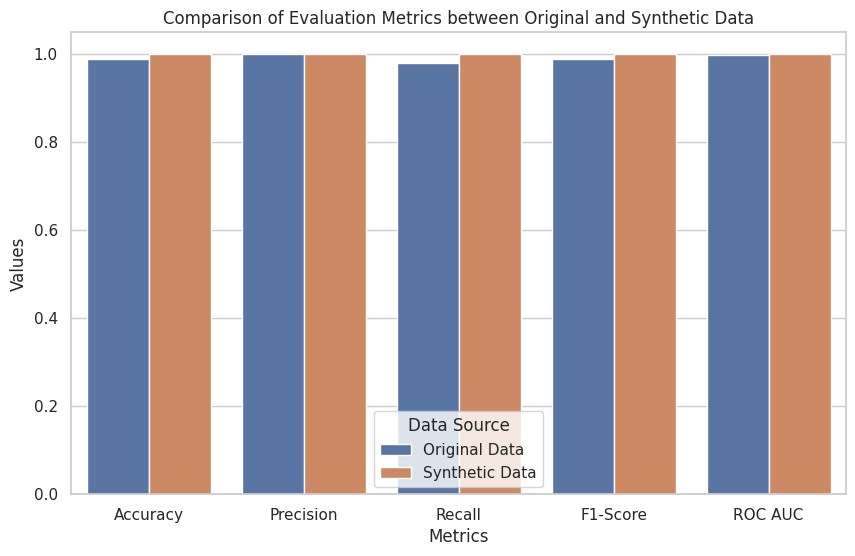

In [39]:
# Melt the DataFrame for Seaborn
comparison_melted = pd.melt(comparison, id_vars=['Metric'], value_vars=['Original Data', 'Synthetic Data'])

# Bar Plot for Comparison
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

barplot = sns.barplot(x='Metric', y='value', hue='variable', data=comparison_melted)

# Add labels and title
barplot.set_xlabel('Metrics')
barplot.set_ylabel('Values')
barplot.set_title('Comparison of Evaluation Metrics between Original and Synthetic Data')

plt.legend(title='Data Source')
plt.show()

## Conclusion

### Key Observations:
- The synthetic data performs exceptionally well, achieving perfect scores (1.0) in all metrics except for a slight difference in accuracy compared to the original data.
- This indicates that the CTGAN model has successfully generated synthetic data with very high fidelity, capturing the critical characteristics of the original dataset.

### Implications:
- The near-perfect performance suggests that the synthetic data can be used as a reliable substitute for the original data in various predictive tasks.
- These results are promising and indicate that the CTGAN model is effective at preserving the essential patterns and relationships within the original dataset.

### Recommendations:
- Further validation using additional datasets or real-world applications would be beneficial to ensure the generalizability of these findings.
- The synthetic data can now be considered a robust alternative for training models, reducing the need for sensitive or proprietary data.

---

This conclusion highlights the strong performance of the synthetic data generated by the CTGAN model, suggesting its utility in various predictive modeling scenarios.